# Bayesian regression with truncated or censored data

**Author:** [Benjamin T. Vincent](https://github.com/drbenvincent)

The notebook provides an example of how to conduct linear regression when your outcome variable is either censored or truncated.

In [1]:
from copy import copy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from numpy.random import default_rng
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf
from scipy.stats import norm, truncnorm

In [2]:
%config InlineBackend.figure_format = 'retina'
rng = default_rng(12345)
az.style.use("arviz-darkgrid")

## Truncation and censoring

Truncation and censoring are examples of missing data problems. It can sometimes be easy to muddle up truncation and censoring, so let's look at some definitions.
 
- **Truncation** is a type of missing data problem where you are simply unaware of any data where the outcome variable falls outside of a certain set of bounds.
- **Censoring** occurs when a measurement has a sensitivity with a certain set of bounds. But rather than discard data outside these bounds, you would record a measurement at the bound which it exceeded.

Let's further explore this with some code and plots. First we will generate some true `(x, y)` scatter data, where `y` is our outcome measure and `x` is some predictor variable.

In [3]:
slope, intercept, σ, N = 1, 0, 2, 200
x = rng.uniform(-10, 10, N)
y = rng.normal(loc=slope * x + intercept, scale=σ)

For this example of `(x, y)` scatter data, we can describe the truncation process as simply filtering out any data for which our outcome variable `y` falls outside of a set of bounds.

In [4]:
def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])

With censoring however, we are setting the `y` value equal to the bounds that they exceed.

In [5]:
def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y <= bounds[0]] = bounds[0]
    cy[y >= bounds[1]] = bounds[1]
    return (x, cy)

Based on our generated `(x, y)` data (which an experimenter would never see in real life), we can generate our actual observed datasets for truncated data `(xt, yt)` and censored data `(xc, yc)`.

In [6]:
bounds = [-5, 5]
xt, yt = truncate_y(x, y, bounds)
xc, yc = censor_y(x, y, bounds)

We can visualise this latent data (in grey) and the remaining truncated or censored data (black) as below.

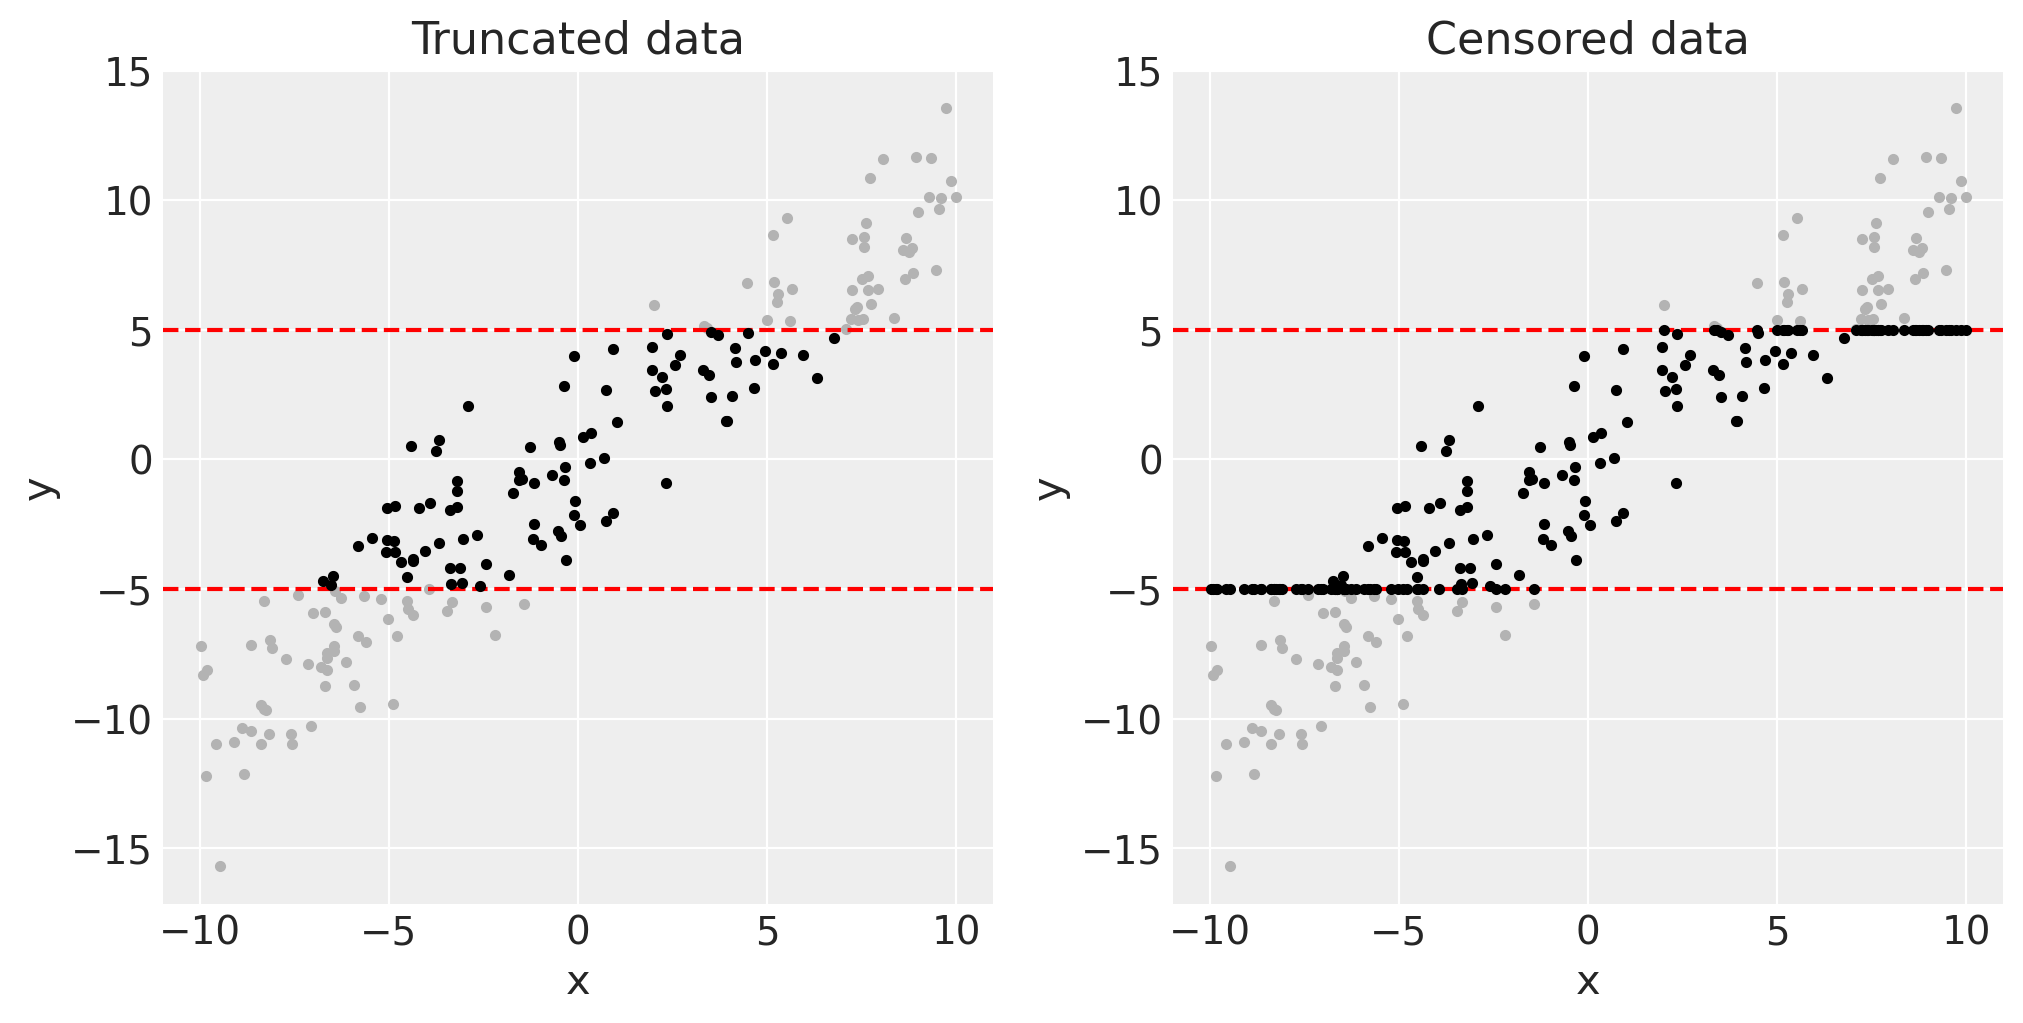

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax in axes:
    ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
    ax.axhline(bounds[0], c="r", ls="--")
    ax.axhline(bounds[1], c="r", ls="--")
    ax.set(xlabel="x", ylabel="y")

axes[0].plot(xt, yt, ".", c=[0, 0, 0])
axes[0].set(title="Truncated data")

axes[1].plot(xc, yc, ".", c=[0, 0, 0])
axes[1].set(title="Censored data");

## The problem that truncated or censored regression solves
If we were to run regular linear regression on either the truncated or censored data, it should be fairly intuitive to see that we will likely underestimate the slope. Truncated regression and censored regress (aka Tobit regression) were designed to address these missing data problems and hopefully result in regression slopes which are free from the bias introduced by truncation or censoring.

In this section we will run Bayesian linear regression on these datasets to see the extent of the problem. We start by defining a function which defines a PyMC3 model, conducts MCMC sampling, and returns the model and the MCMC sampling data.

In [8]:
def linear_regression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        σ = pm.HalfNormal("σ", sd=1)
        y = pm.Normal("y", mu=slope * x + intercept, sigma=σ, observed=y)

    return model

So we can run this on our truncated and our censored data, seperately.

In [9]:
trunc_linear_model = linear_regression(xt, yt)

with trunc_linear_model:
    trunc_linear_fit = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [10]:
cens_linear_model = linear_regression(xc, yc)

with cens_linear_model:
    cens_linear_fit = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


By plotting the posterior distribution over the slope parameters we can see that the estimates for the slope are pretty far off, so we are indeed underestimating the regression slope.

[Text(0.5, 1.0, 'Linear regression\n(censored data)'), Text(0.5, 0, 'slope')]

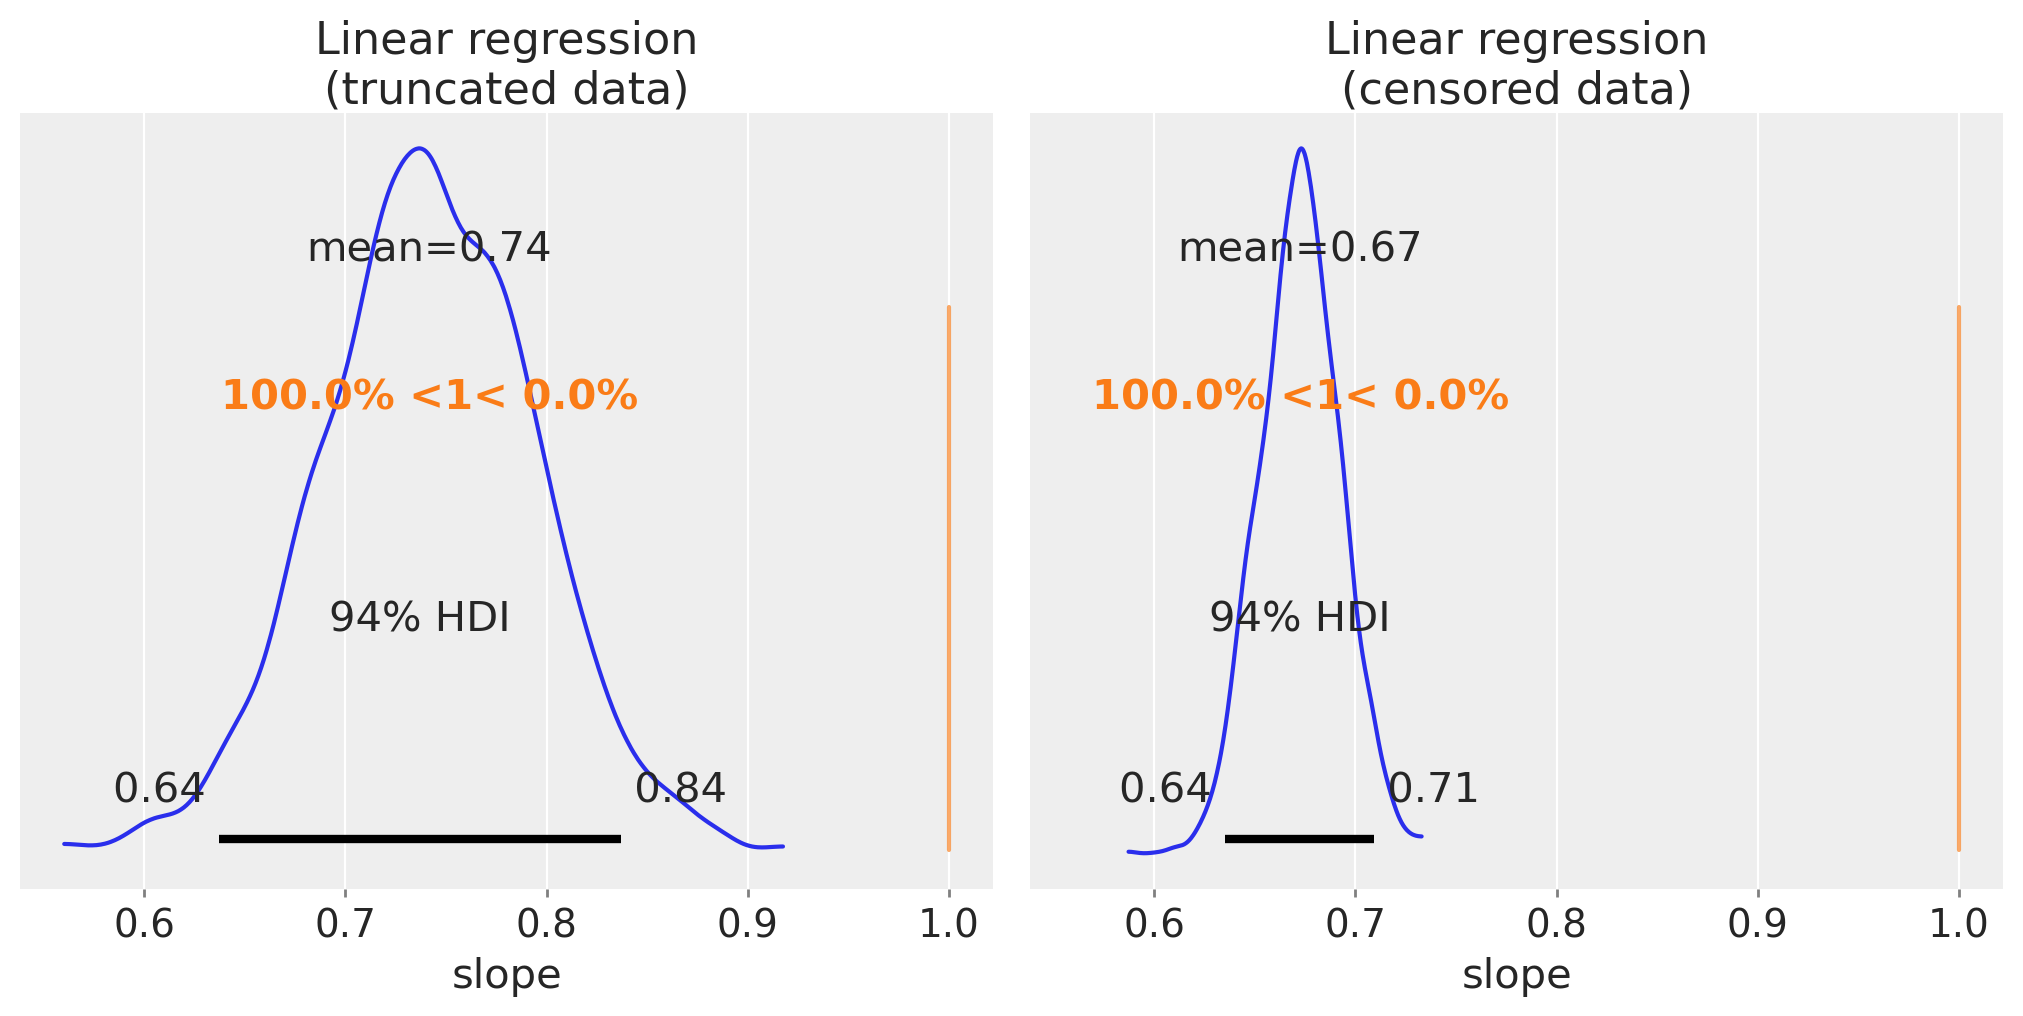

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(trunc_linear_fit, var_names=["slope"], ref_val=slope, ax=ax[0])
ax[0].set(title="Linear regression\n(truncated data)", xlabel="slope")

az.plot_posterior(cens_linear_fit, var_names=["slope"], ref_val=slope, ax=ax[1])
ax[1].set(title="Linear regression\n(censored data)", xlabel="slope")

To appreciate the extent of the problem (for this dataset) we can visualise the posterior predictive fits alongside the data.

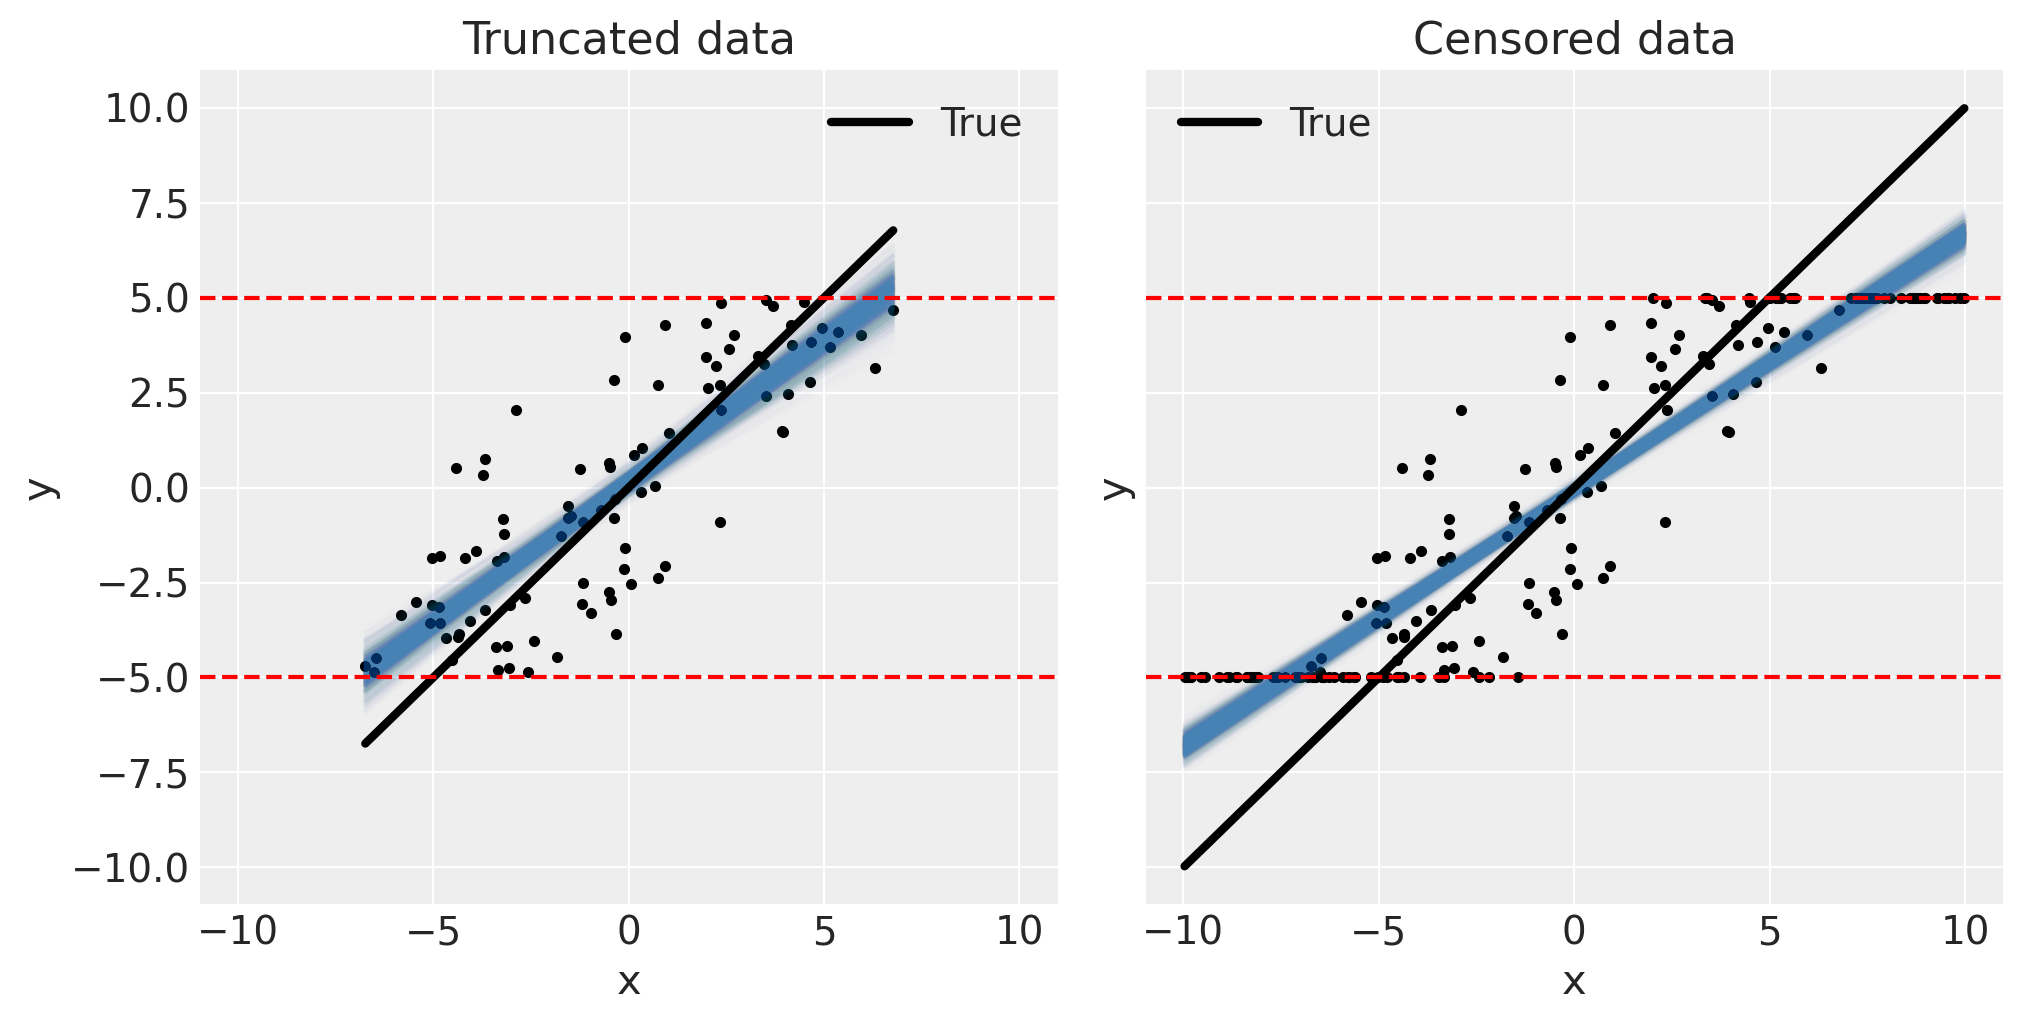

In [12]:
def pp_plot(x, y, fit, ax):
    # plot data
    ax.plot(x, y, "k.")
    # plot posterior predicted... samples from posterior
    xi = np.array([np.min(x), np.max(x)])
    n_samples = 1000
    for n in range(n_samples):
        slope_sample = fit.posterior["slope"].values[1, n]
        intercept_sample = fit.posterior["intercept"].values[1, n]
        y_ppc = xi * slope_sample + intercept_sample
        ax.plot(xi, y_ppc, c="steelblue", alpha=0.01, rasterized=True)
    # plot true
    ax.plot(xi, slope * xi + intercept, "k", lw=3, label="True")
    # plot bounds
    ax.axhline(bounds[0], c="r", ls="--")
    ax.axhline(bounds[1], c="r", ls="--")
    ax.legend()
    ax.set(xlabel="x", ylabel="y")


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

pp_plot(xt, yt, trunc_linear_fit, ax[0])
ax[0].set(title="Truncated data")

pp_plot(xc, yc, cens_linear_fit, ax[1])
ax[1].set(title="Censored data");

By looking at these plots we can intuitively predict what factors will influence the extent of the underestimation bias. Firstly, if the truncation or censoring bounds are very broad such that they only affect a few data points, then the underestimation bias would be smaller. Secondly, if the measurement error `σ` is low, we might expect the underestimation bias to decrease. In the limit of zero measurement noise then it should be possible to fully recover the true slope despite truncation or censoring. Regardless, it would be prudent to use truncated or censored regression models unless the measurement error is near zero, or the bounds are so broad as to be practically irrelevant.

## Implementing truncated and censored regression models
Now we have seen the problem of conducting regression on truncated or censored data, in terms of underestimating the regression slopes. This is what truncated or censored regression models were designed to solve. The general approach taken by both truncated and censored regression is to encode our prior knowledge of the truncation or censoring steps in the data generating process. This is done by modifying the likelihood function in various ways.

### Truncated regression model
Truncated regression models are quite simple to implement. The normal likelihood is centered on the regression slope as normal, but now we just specify a normal distribution which is truncated at the bounds.

In [13]:
def truncated_regression(x, y, bounds):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        σ = pm.HalfNormal("σ", sigma=1)

        y_likelihood = pm.TruncatedNormal(
            "y_likelihood",
            mu=slope * x + intercept,
            sigma=σ,
            observed=y,
            lower=bounds[0],
            upper=bounds[1],
        )
    return model

Truncated regression solves the bias problem by updating the likelihood to reflect our knowledge about the process generating the observations. Namely, we have zero chance of observing any data outside of the truncation bounds, and so the likelihood should reflect this. We can visualise this in the plot below, where compared to a normal distribution, the probability density of a truncated normal is zero outside of the truncation bounds $(y<-1)$ in this case.

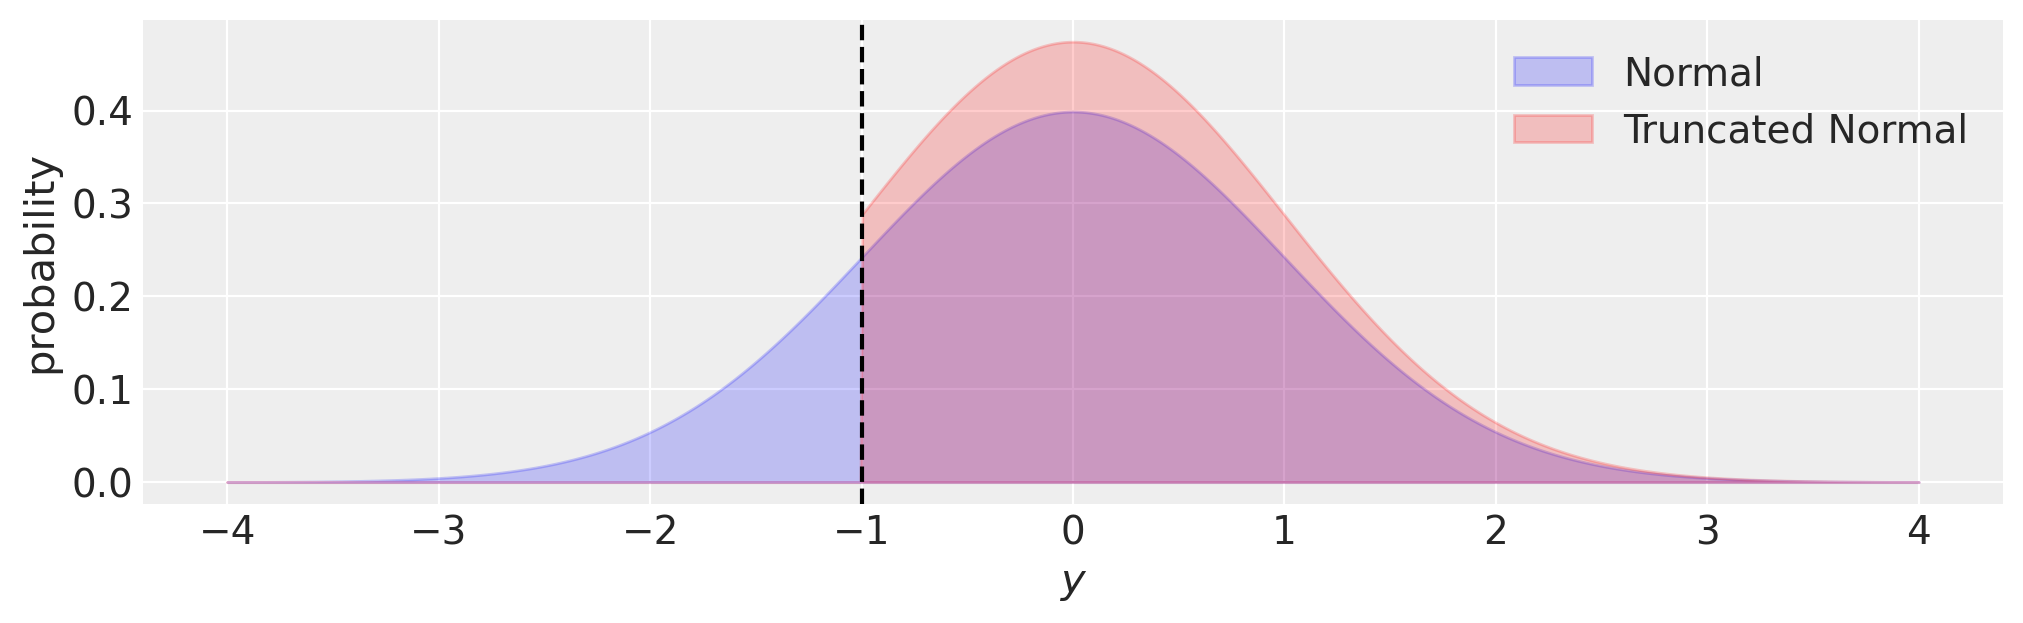

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))
y = np.linspace(-4, 4, 1000)
ax.fill_between(y, norm.pdf(y, loc=0, scale=1), 0, alpha=0.2, ec="b", fc="b", label="Normal")
ax.fill_between(
    y,
    truncnorm.pdf(y, -1, float("inf"), loc=0, scale=1),
    0,
    alpha=0.2,
    ec="r",
    fc="r",
    label="Truncated Normal",
)
ax.set(xlabel="$y$", ylabel="probability")
ax.axvline(-1, c="k", ls="--")
ax.legend();

### Censored regression model
Implementing the censored regression model is a little more involved, but not much so. First there is some data pre-processing. This takes in the raw data and splits it into 3 seperate groups based upon left/lower censoring, uncensored, or right/upper censoring. Each of these groups have their own likelihood.
- The likelihood of lower censored data is set at the area to the left of the lower bound.
- Uncensored data is dealt with using a regular normal likelihood function.
- The likelihood of the upper censored data is set as the area to the right of the upper bound.

In [15]:
def censored_regression(x, y, bounds):

    # data pre-processing
    left_censored = y <= bounds[0]  # <= rather than == for numerical safety
    x_lc = x[left_censored]
    y_lc = y[left_censored]

    right_censored = y >= bounds[1]  # >= rather than == for numerical safety
    x_rc = x[right_censored]
    y_rc = y[right_censored]

    uncensored = (y > bounds[0]) & (y < bounds[1])
    x = x[uncensored]
    y = y[uncensored]

    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=σ, observed=y)
        left_censored = pm.Potential(
            "left_censored", normal_lcdf(slope * x_lc + intercept, σ, y_lc)
        )
        right_censored = pm.Potential(
            "right_censored", normal_lccdf(slope * x_rc + intercept, σ, y_rc)
        )

    return model

What is happening here? Again, we incorporate our knowledge of the process generating the data into the likelihood:
- we know that there will be no observations outside the bounds
- we know that data within the bounds will be observed as normal
- we know that if there is data beyond the bounds, then we should see observations at the exact value of the bound.

The likelihood term in the censored model above reflects this knowledge. Observations which are not censored are dealt with by `y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=σ, observed=y)` as you would expect. But the likelihood of data beyond the bounds is set equal to the probability mass beyond the bound. This is what is being done with `left_censored = pm.Potential("left_censored", normal_lcdf(slope * x_lc + intercept, σ, y_lc))` for example.

So in the figure below, the probability density at $y=-1$ is equal to the cumulative probability density of the normal distribution from $-\infty$ to $-1$.

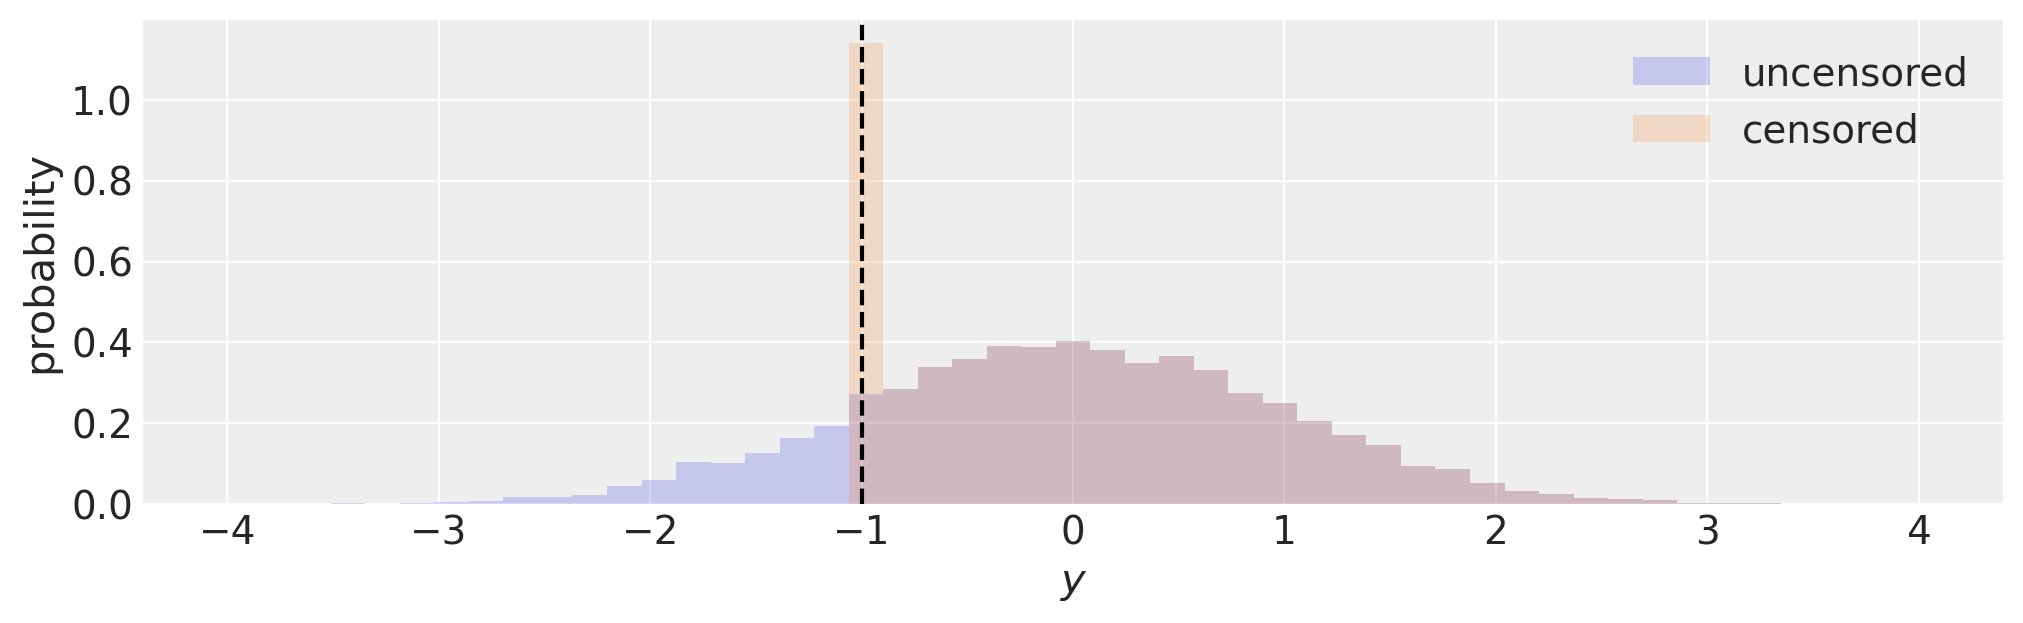

In [16]:
fig, ax = plt.subplots(figsize=(10, 3))
edges = np.linspace(-4, 4, 50)

y = norm.rvs(loc=0, scale=1, size=10_000)
ax.hist(y, bins=edges, density=True, histtype="stepfilled", alpha=0.2, label="uncensored")

y[y < -1] = -1
ax.hist(y, bins=edges, density=True, histtype="stepfilled", alpha=0.2, label="censored")

ax.set(xlabel="$y$", ylabel="probability")
ax.axvline(-1, c="k", ls="--")
ax.legend();

## Run the truncated and censored regressions
Now we can conduct our parameter estimation with the truncated regression model on the truncated data...

In [17]:
truncated_model = truncated_regression(xt, yt, bounds)

with truncated_model:
    truncated_fit = pm.sample(return_inferencedata=True)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


and with the censored regression model on the censored data.

In [18]:
censored_model = censored_regression(xc, yc, bounds)

with censored_model:
    censored_fit = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


We can do the same as before and visualise our posterior estimates on the slope.

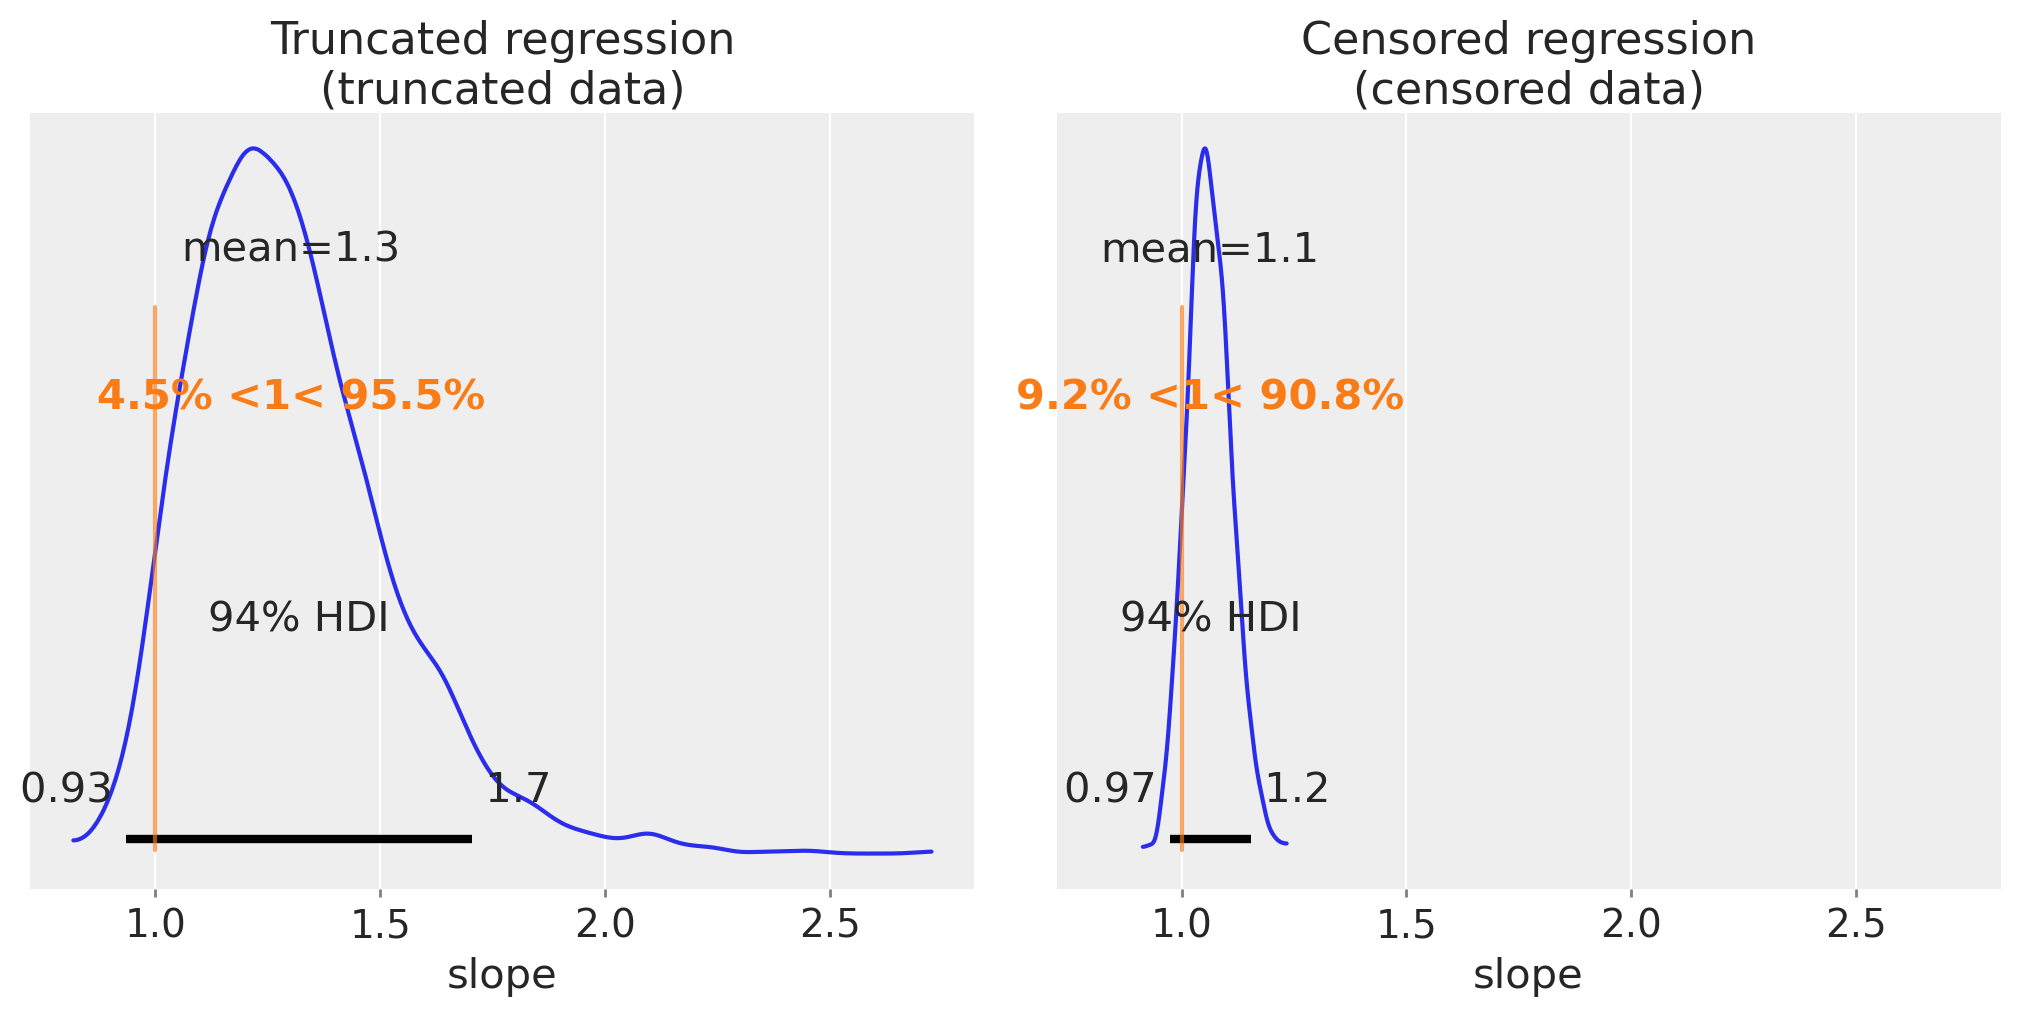

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(truncated_fit, var_names=["slope"], ref_val=slope, ax=ax[0])
ax[0].set(title="Truncated regression\n(truncated data)", xlabel="slope")

az.plot_posterior(censored_fit, var_names=["slope"], ref_val=slope, ax=ax[1])
ax[1].set(title="Censored regression\n(censored data)", xlabel="slope");

These are _much_ better estimates. Interestingly, we can see that the estimate for censored regression is more precise than for truncated data. This will not necessarily always be the case, but the intuition here is that the `x` and `y` data is entirely discarded with truncation, but only the `y` data becomes partially unknown in censoring.

We could speculate then, that if an experimenter had the choice of truncating or censoring data, it might be better to opt for censoring over truncation.

Correspondingly, we can confirm the models are good through visual inspection of the posterior predictive plots.

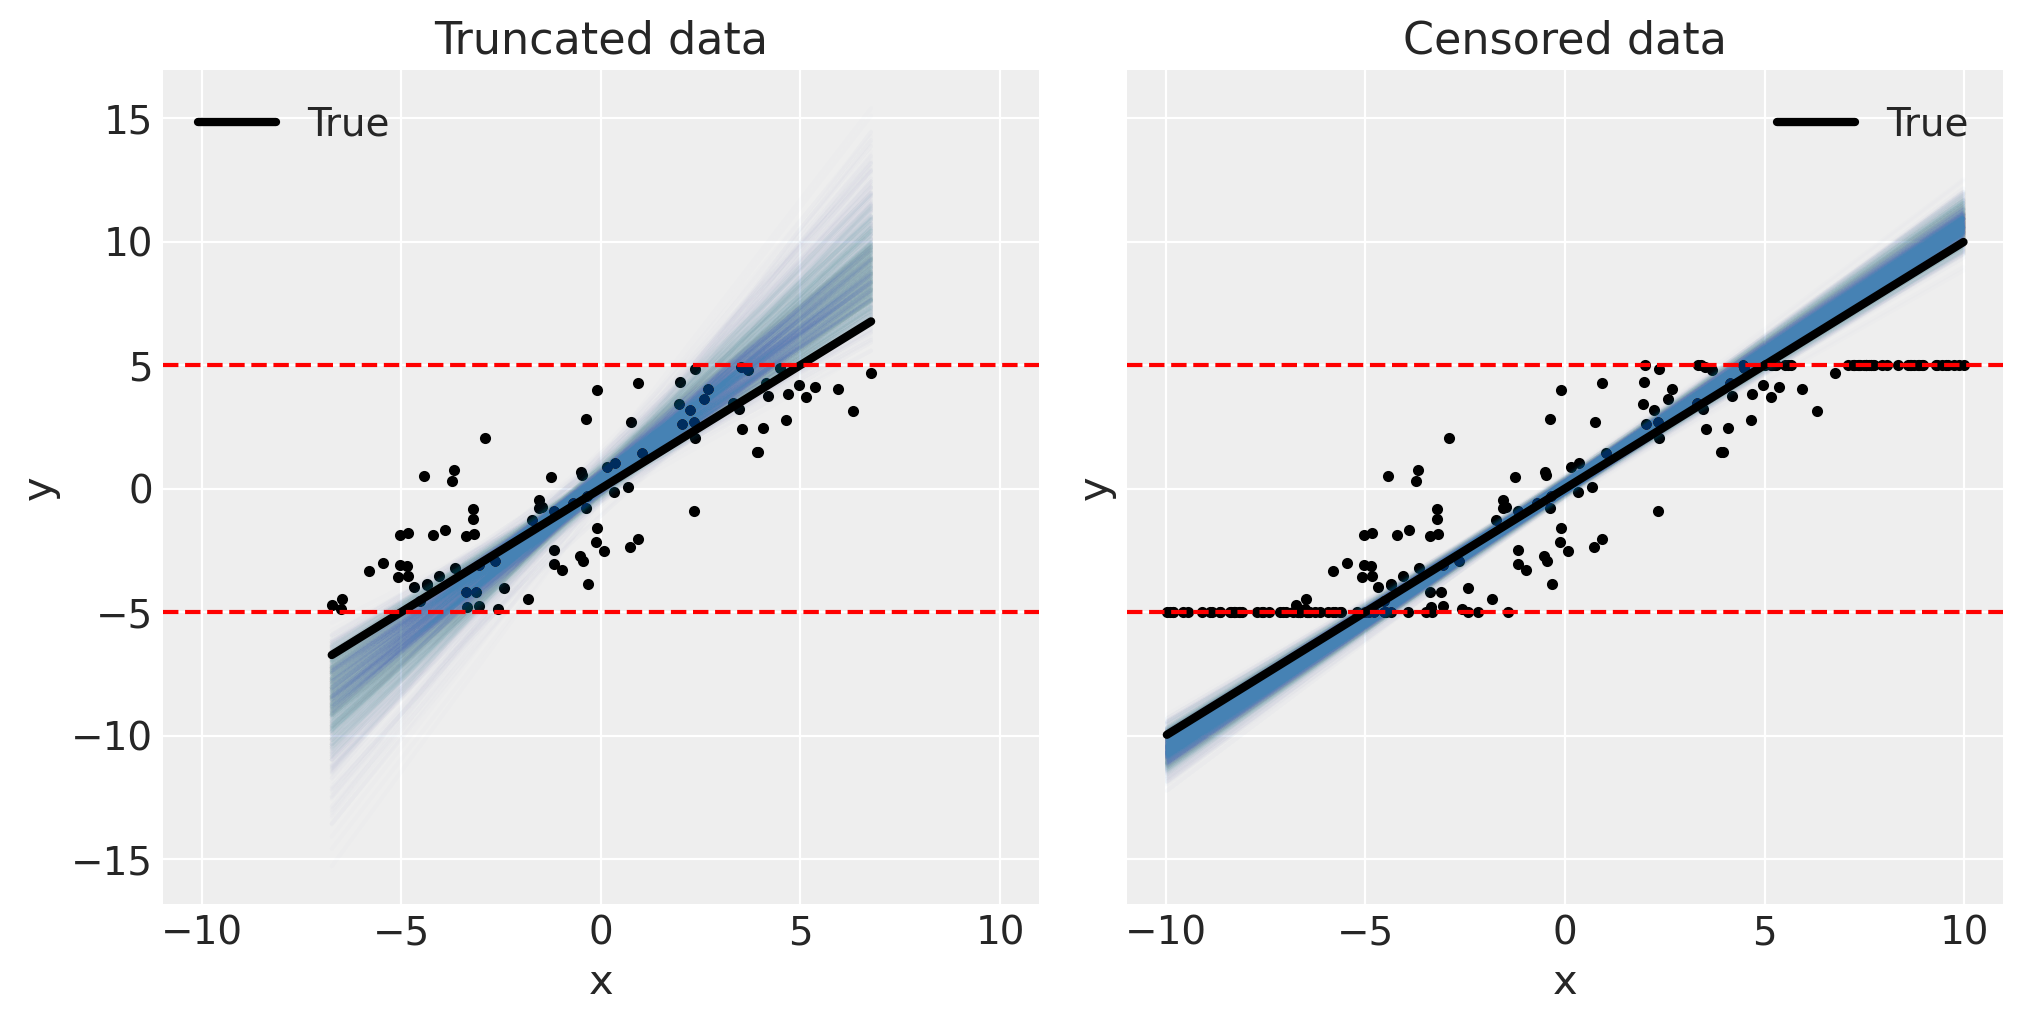

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

pp_plot(xt, yt, truncated_fit, ax[0])
ax[0].set(title="Truncated data")

pp_plot(xc, yc, censored_fit, ax[1])
ax[1].set(title="Censored data");

This brings an end to our guide on truncated and censored data and truncated and censored regression models in PyMC3. While the extent of the regression slope estimation bias will vary with a number of factors discussed above, hopefully these examples have convinced you of the importance of encoding your knowledge of the data generating process into regression analyses.

## Further topics
It is also possible to treat the bounds as unknown latent parameters. If these are not known exactly and it is possible to fomulate a prior over these bounds, then it would be possible to infer what the bounds are. This could be argued as overkill however - depending on your data analysis context it may be entirely sufficient to extract 'good enough' point estimates of the bounds in order to get reasonable regression estimates.

The censored regression model presented above takes one particular approach, and there are others. For example, it did not attempt to infer posterior beliefs over the true latent `y` values of the censored data. It is possible to build censored regression models which do impute these censored `y` values, but we did not address that here as the topic of [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)) deserves its own focussed treatment. The PyMC3 [Censored Data Models](https://docs.pymc.io/notebooks/censored_data.html) example also covers this topic, with a particular [example model to impute censored data](https://docs.pymc.io/notebooks/censored_data.html#Model-1---Imputed-Censored-Model-of-Censored-Data). 

## Further reading
When looking into this topic, I found that most of the material out there focusses on maximum likelihood estimation approaches, with focus on mathematical derivation rather than practical implementation. One good concise mathematical 80 page booklet by Breen (1996) covers truncated and censored as well as other missing data scenarios. That said, a few pages are given over to this topic in Bayesian Data Analysis by Gelman et al (2013), and Gelman et al (2020).

## References
- Breen, R. (1996). Regression models: Censored, sample selected, or truncated data (Vol. 111). Sage. [[Google Books link](https://books.google.co.uk/books?hl=en&lr=&id=btrvKnZSqIIC&oi=fnd&pg=PP7#v=onepage), [Publisher link](https://us.sagepub.com/en-us/nam/book/regression-models)]
- Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian data analysis. CRC press. [[Publisher link](https://www.routledge.com/Bayesian-Data-Analysis/Gelman-Carlin-Stern-Dunson-Vehtari-Rubin/p/book/9781439840955)]
- Gelman, A., Hill, J., & Vehtari, A. (2020). Regression and other stories. Cambridge University Press. [[Publisher link](https://www.cambridge.org/core/books/regression-and-other-stories/DD20DD6C9057118581076E54E40C372C)]

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano

Last updated: Thu May 13 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

theano: 1.1.2

numpy     : 1.19.2
pymc3     : 3.11.1
matplotlib: 3.3.2
arviz     : 0.11.0

Watermark: 2.1.0

